# Imports

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torchsummary import summary

# MobileNet-v1 + FPN

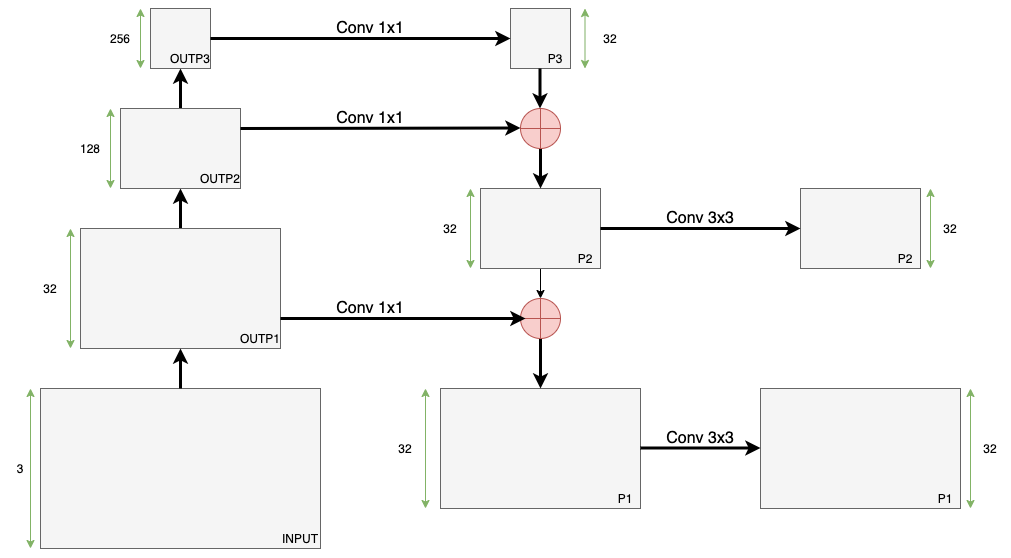

In [2]:
class MobileNetV1_FPN(nn.Module):
    def __init__(self, in_channel=3, n_classes=1):
        super(MobileNetV1_FPN, self).__init__()
        self.num_features_out = 32

        def conv_bn(inp, outp, stride):
            """
            Convolutional Layer with Batch Normalization
            """
            return nn.Sequential(
                nn.Conv2d(in_channels=inp, out_channels=outp, kernel_size=3, stride=stride, padding=1, bias=False),
                nn.BatchNorm2d(outp, affine=False),
                nn.ReLU(inplace=True)
            )

        def conv_dsc(inp, outp, stride):
            """
            conv_dsc: Depthwise Separable Convolutional Layer
            If we set groups=1 as we did by default, then this is a normal conv.
            If we set it to groups=inp, then it is a Depthwise conv.
            """
            return nn.Sequential(
                # Depthwise Layer
                nn.Conv2d(in_channels=inp, out_channels=inp, kernel_size=3, stride=stride, padding=1, groups=inp, bias=False),
                nn.BatchNorm2d(inp, affine=False),
                nn.ReLU(inplace=True),

                # Pointwise Layer
                nn.Conv2d(in_channels=inp, out_channels=outp, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(outp, affine=False),
                nn.ReLU(inplace=True),
            )
    
        
        # FPN Outputs
        self.fpn1 = nn.Sequential(
            conv_bn(in_channel, 8, 2),
            conv_dsc(8, 16, 1),
            conv_dsc(16, 32, 2),
            conv_dsc(32, 32, 1)
        )
        
        self.fpn2 = nn.Sequential(
            conv_dsc(32, 64, 2),
            conv_dsc(64, 64, 1),
            conv_dsc(64, 128, 2),
            conv_dsc(128, 128, 1),
            conv_dsc(128, 128, 1),
            conv_dsc(128, 128, 1),
            conv_dsc(128, 128, 1),
            conv_dsc(128, 128, 1)
        )
        
        self.fpn3 = nn.Sequential(
            conv_dsc(128, 256, 2),
            conv_dsc(256, 256, 2)
        )
        
        # Lateral 1x1 Convolutions
        self.lateral_fpn1 = nn.Conv2d(in_channels=32, out_channels=self.num_features_out, kernel_size=1)
        self.lateral_fpn2 = nn.Conv2d(in_channels=128, out_channels=self.num_features_out, kernel_size=1)
        self.lateral_fpn3 = nn.Conv2d(in_channels=256, out_channels=self.num_features_out, kernel_size=1)
        
        # 3x3 Convolutions for Dealising 
        self.dealiasing_fpn1 = nn.Conv2d(in_channels=self.num_features_out, out_channels=self.num_features_out, kernel_size=3, padding=1)
        self.dealiasing_fpn2 = nn.Conv2d(in_channels=self.num_features_out, out_channels=self.num_features_out, kernel_size=3, padding=1)
        
        
    def forward(self, x):
        
        # Bottom-up pathway
        outp1 = self.fpn1(x)
        outp2 = self.fpn2(outp1)
        outp3 = self.fpn3(outp2)
        
        # Top-down pathway and lateral connections
        p3 = self.lateral_fpn3(outp3)
        p2 = self.lateral_fpn2(outp2) + F.interpolate(input=p3, size=(outp2.shape[2], outp2.shape[3]), mode='nearest')
        p1 = self.lateral_fpn1(outp1) + F.interpolate(input=p2, size=(outp1.shape[2], outp1.shape[3]), mode='nearest')
        
        # Reduce the aliasing effect
        p2 = self.dealiasing_fpn2(p2)
        p1 = self.dealiasing_fpn1(p1)
        
        return p1, p2, p3

# Detection

In [ ]:
model = MobileNetV1_FPN()
summary(model, input_size=(3, 448, 448), device='cpu')

In [5]:
class Yolo(nn.Module):
    def __init__(self, in_channels=3, split_size = 7, num_boxes = 2, num_classes = 1):
        super(Yolo, self).__init__()
        self.S, self.B, self.C = split_size, num_boxes, num_classes
        self.backbone = MobileNetV1_FPN(in_channels, num_classes)
        self.point_conv3 = nn.Conv2d(in_channels=32, out_channels=12, kernel_size=1, stride=1)
        self.point_conv2 = nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1, stride=1)
        self.point_conv1 = nn.Conv2d(in_channels=2048, out_channels=3, kernel_size=1, stride=1)
        
    def forward(self, x):
        # FPN outputs
        print(x.shape)
        x1, x2, x3 = self.backbone(x)
        
        # Reshape for 1x1 Convs
        x1 = x1.reshape(x1.shape[0], 2048, 14, 14)
        x2 = x2.reshape(x2.shape[0], 128, 14, 14)
        
        # 1x1 Convs
        x1 = self.point_conv1(x1)
        x2 = self.point_conv2(x2)
        x3 = self.point_conv3(x3)
        
        # [..., 7, 7, 12]
        x1 = x1.view(-1, self.S, self.S, self.B * (self.C + 5))
        x2 = x2.view(-1, self.S, self.S, self.B * (self.C + 5))
        x3 = x3.view(-1, self.S, self.S, self.B * (self.C + 5))

        return x1, x2, x3

    


In [6]:
model = Yolo()
summary(model, input_size=(3, 448, 448), device='cpu')

torch.Size([2, 3, 448, 448])
p1: torch.Size([2, 32, 112, 112])
p2: torch.Size([2, 32, 28, 28])
p3: torch.Size([2, 32, 7, 7])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 8, 224, 224]             216
       BatchNorm2d-2          [-1, 8, 224, 224]               0
              ReLU-3          [-1, 8, 224, 224]               0
            Conv2d-4          [-1, 8, 224, 224]              72
       BatchNorm2d-5          [-1, 8, 224, 224]               0
              ReLU-6          [-1, 8, 224, 224]               0
            Conv2d-7         [-1, 16, 224, 224]             128
       BatchNorm2d-8         [-1, 16, 224, 224]               0
              ReLU-9         [-1, 16, 224, 224]               0
           Conv2d-10         [-1, 16, 112, 112]             144
      BatchNorm2d-11         [-1, 16, 112, 112]               0
             ReLU-12         [-1, 16, 112,